# Тесты с генетическим алгоритмом (мутации)

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [2]:
def print_NRS_graph(model):
    '''
    Построение графа НРС
    '''
    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        plt.show()

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model):
    '''
    Построение графа НРС
    '''
    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nx.draw(G, with_labels=True)
    plt.show()

    return G
# from workFolder.nrs import q_out_simple

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        # self.pumps=[]
        # self.hoses=[]
        # self.inhoses=[]
        # self.splitters=[]
        # self.joiners=[]
        # self.nozzles=[]
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'НРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)

        # if isinstance(elmnt, GA_Element_Pump):
        #     # self.pumps.append(elmnt)
        #     if elmnt.name=='': elmnt.name='Н'+str(self.counter)
        # if isinstance(elmnt, GA_Element_Hose):
        #     # self.hoses.append(elmnt)
        #     if elmnt.name=='': elmnt.name='НРЛ'+str(self.counter)
        # if isinstance(elmnt, GA_Element_InHose):
        #     # self.inhoses.append(elmnt)
        #     if elmnt.name=='': elmnt.name='ВРЛ'+str(self.counter)
        # if isinstance(elmnt, GA_Element_Splitter):
        #     # self.splitters.append(elmnt)
        #     if elmnt.name=='': elmnt.name='Р'+str(self.counter)
        # if isinstance(elmnt, GA_Element_Joiner):
        #     # self.joiners.append(elmnt)
        #     if elmnt.name=='': elmnt.name='ВС'+str(self.counter)
        # if isinstance(elmnt, GA_Element_Nozzle):
        #     # self.nozzles.append(elmnt)
        #     if elmnt.name=='': elmnt.name='Ств'+str(self.counter)
            
        return super().appendElement(elmnt)

    def crossing(self, pair_model):
        return self

    def mutate(self, mutation_count=1):
        '''
        Мутация элементов модели
        '''
        for _ in range(mutation_count):
            random.choice(self.elmnts).mutate()


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    

class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add > self.H_max:
            self.H_add = self.H_max
        else:
            self.H_add = H_add
        if H_add <= self.H_min:
            self.H_add = self.H_min
        else:
            self.H_add = H_add

    def mutate(self):
        mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.H_add+=change_val
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)




class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-5,5)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(list(NRS_Data.ss.keys()))
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
        # мутация типа

        # разбиение

class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества выходов
        change_val = random.choice([2,3,4,5])
        self.set_ro(change_val)

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        change_val = random.choice([2,3,4,5])
        self.set_ri(change_val)

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)


# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }


# (GA_Element_Hose,GA_Element_Pump,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter,GA_Element_InHose)

#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()

In [169]:
[i for i in range(-5,5)]

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]

# Тесты

In [3]:
p_nozzleB = NRS_Revision.calc_p(3.7, 40)
p_nozzleA = NRS_Revision.calc_p(7.4, 40)
p_nozzleL = NRS_Revision.calc_p(16, 40)
p_nozzleB, p_nozzleA, p_nozzleL

def get_elements_sack():
    elements_sack = []
    elements_sack.append(GA_Element_Pump('', e_type=1, H_add=40))
    # elements_sack.append(GA_Element_Pump('', e_type=0, H_add=60))
    # elements_sack.append(GA_Element_Pump('', e_type=0, H_add=80))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=4))
    elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=6))
    # elements_sack.append(GA_Element_Hose('', e_type=1, s=NRS_Data.ss["77"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2))
    elements_sack.append(GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=4))
    elements_sack.append(GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=6))
    elements_sack.append(GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleB, q_out = q_out_nozzle))
    elements_sack.append(GA_Element_Nozzle('', e_type=2, n_type='А', p=p_nozzleA, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleA, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Nozzle('', e_type=2, p=p_nozzleL, q_out = q_out_nozzle))
    # elements_sack.append(GA_Element_Joiner('', e_type=1, ri=2, ro=1))
    elements_sack.append(GA_Element_Splitter('', e_type=1, ri=1, ro=3))
    # elements_sack.append(GA_Element_Splitter('', e_type=1, ri=1, ro=3))

    return elements_sack

## Слепой часовщик

In [4]:
tmp_list = [e for e in elements_sack]

while len(tmp_list)>0:
    elmnt = tmp_list.pop(random.randrange(len(tmp_list)))
    # next_elmnt  = random.choice(elements_sack)
    elements_for_append = [e for e in elements_sack if e!=elmnt]
    elmnt.append(random.choice(elements_for_append))

# Сборка модели
model = GA_model('Тест слепой часовщик')
# model.build(pump, interpretate=True).observersInit()
# model.addElements([pump, hoseW1, nozzle1], interpretate=True).observersInit()
model.addElements(elements_sack).check_pumps().interpretate()  #.observersInit()

# Расчет 
model.calc(accuracy=0.05)
print(model.summaryQ(), end='\n\n')

print('Статус насоса:')
NRS_Revision.print_element_state(pump, ['H_add', 'q'])

NameError: name 'elements_sack' is not defined

Расстояние до Н0 0 м
Полный граф изобразить не возможно, будет отображен упрощенный


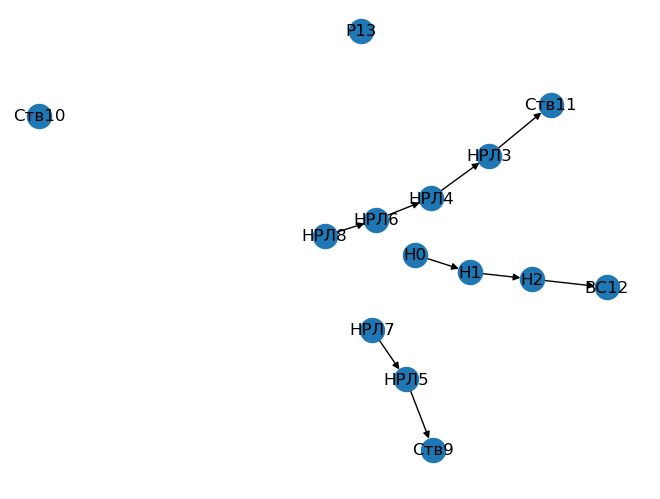

In [ ]:
print_NRS_graph(model)

In [ ]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  Н1
  Н2
  НРЛ3
  НРЛ4
  НРЛ5
  НРЛ6
  НРЛ7
  НРЛ8
  Ств9
  Ств10
  Ств11
  ВС12
  Р13
in:
  Н0
out:
  Ств9
  Ств10
  Ств11


## Построение деревьев

### Тест прямого (явного) построения ветви

In [ ]:
elements_sack = get_elements_sack()

model = GA_model('Тест деревья')
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
hose = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)
pump.append(hose).append(nozzle)


model.addElements([pump,hose,nozzle]).check_pumps().interpretate()

NRS_Revision.print_model_elements(model)

print_NRS_graph(model)

### Тест рекурсивного построения дерева

Новая модель: Тест дерева - рекурсия
11
10
Достигнут предел рекурсии
10
all:
  Н0
  НРЛ1
  НРЛ2
  НРЛ3
  НРЛ4
  НРЛ5
in:
  Н0
out:
Расстояние до Н0 160 м


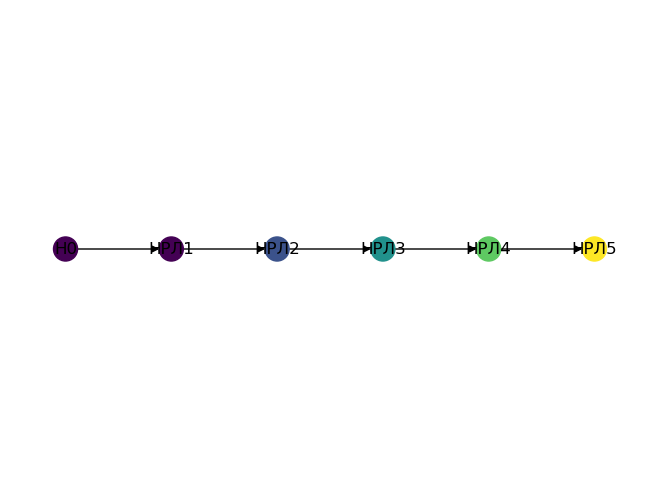

In [ ]:
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

# global depth
depth=25


# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()


# Рекурсия
model = GA_model('Тест дерева - рекурсия')
print(len(elements_sack))
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=False)
print(len(elements_sack))
append_new_element(pump, elements_sack, lst_left=True)  #, add_elmnts_p=1)
print(len(elements_sack))

model.build(pump).check_pumps().interpretate()

# model.addElements([pump,hose,nozzle]).check_pumps().interpretate()

NRS_Revision.print_model_elements(model)

print_NRS_graph(model)

In [ ]:
elements_sack

In [ ]:
# Расчет
# model.calc(iters=10)
model.calc(accuracy=0.5)
# print(model.summaryQ(), end='\n\n')

(<__main__.GA_model at 0x193182eb590>, 22)

In [ ]:
model.calc(iters=10)

(<__main__.GA_model at 0x25f87f89ac0>, -2.930278242274653e-11)

In [ ]:
model.drop_q()

In [ ]:
print(model.summaryQ(), end='\n\n')

5.224119424357346



In [ ]:
NRS_Revision.print_model_elements(model)

all:
  Н0
  НРЛ1
  НРЛ2
  НРЛ3
  Р4
  НРЛ5
  Ств6
  НРЛ7
  Ств8
in:
  Н0
out:
  Ств6
  Ств8


In [ ]:
# NRS_Revision.print_element_state(
#     NRS_Revision.get_element_by_name(model.elmnts, 'НРЛ1', False),
#     ['L', 's']
#     )
# NRS_Revision.print_element_state(
#     NRS_Revision.get_element_by_name(model.elmnts, 'НРЛ3', False),
#     ['L', 's']
#     )
NRS_Revision.print_element_state(
    NRS_Revision.get_element_by_name(model.elmnts, 'Ств6', False),
    ['p','q', 'H_in']
    )
NRS_Revision.print_element_state(
    NRS_Revision.get_element_by_name(model.elmnts, 'Ств8', False),
    ['p','q', 'H_in']
    )

p: 1.1700427342623003
q: (1.7898509347521625e-16+2.923048402197803j)
H_in: (-6.241206692177597+2.3092022000261308e-16j)
p: 0.5850213671311502
q: (3.545608462099151+0j)
H_in: (36.73145176481843+0j)


## Процедура рекурсивного удаления *мертвых* элементов

Мертвые здесь - элементы не входящие в ветви:

* промежуточные элементы не имеющие соединения на вход и выход
* выходы (стволы) не имеющие соединения на вход
* входы (насосы) не имеющие соединения на вход

Новая модель: Тест удаления мертвых элементов
11
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  Ств4
  НРЛ5
in:
  Н0
out:
  Ств4
Расстояние до Н0 80 м


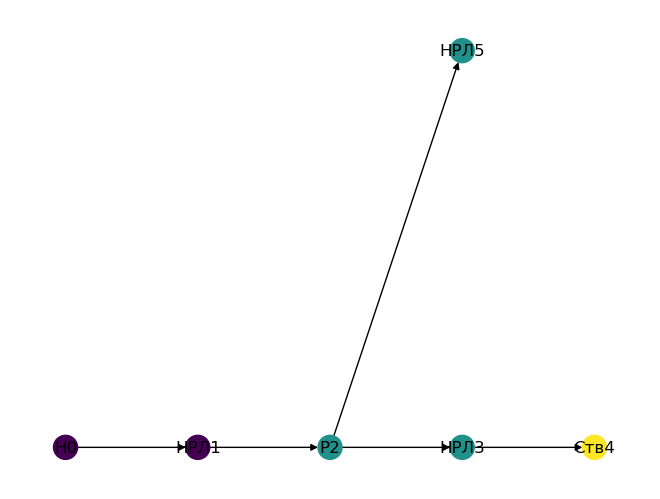

Н0
НРЛ1
Р2
НРЛ3
Ств4
НРЛ5
Р2
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  Ств4
in:
  Н0
out:
  Ств4
Расстояние до Н0 80 м


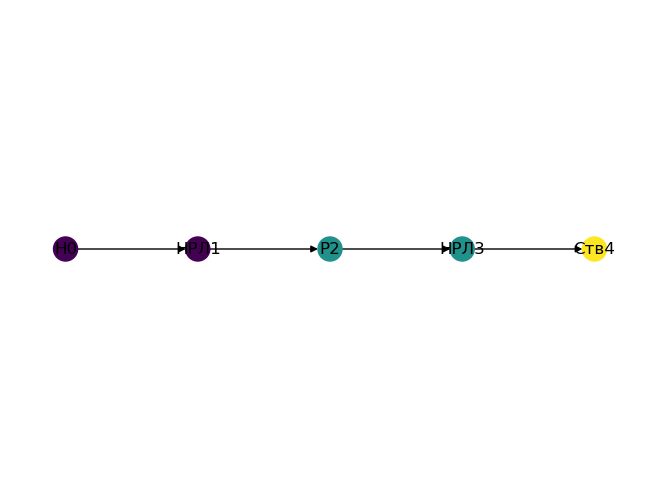

3.354637193497979



In [ ]:
def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model


# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()

# Рекурсия
model = GA_model('Тест удаления мертвых элементов')
print(len(elements_sack))
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
hoseM1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
splitter = pop_random_element_by_class(elements_sack, GA_Element_Splitter, lst_left=True)
hoseW1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW2 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW3 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)

# Живая линия
pump.append(hoseM1).append(splitter).append(hoseW1).append(nozzle)
# Мертвая линия
splitter.append(hoseW2).append(hoseW3)

model.build(pump).check_pumps().interpretate()
NRS_Revision.print_model_elements(model)
print_NRS_graph(model)

# Удаление элемента:
# fire_dead_elements_try(model, hoseW3).check_pumps().interpretate()
for elmnt in model.elmnts:
    fire_dead_elements_try(model, elmnt).check_pumps().interpretate()
NRS_Revision.print_model_elements(model)
print_NRS_graph(model)

# Расчет
# model.calc(iters=10)
model.calc(accuracy=0.5)
print(model.summaryQ(), end='\n\n')

Новая модель: Тест дерева - рекурсия
Достигнут предел рекурсии
Достигнут предел рекурсии
Достигнут предел рекурсии
Достигнут предел рекурсии
Достигнут предел рекурсии
Достигнут предел рекурсии
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  НРЛ4
  Р5
  НРЛ6
  НРЛ7
  НРЛ8
  НРЛ9
in:
  Н0
out:
Расстояние до Н0 160 м


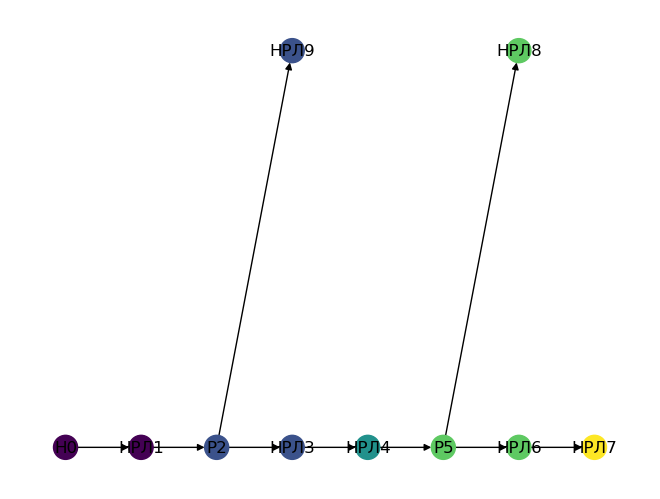

вход в рекурсию Н0
Н0
вход в рекурсию НРЛ1
НРЛ1
вход в рекурсию Р2
Р2
вход в рекурсию НРЛ3
НРЛ3
вход в рекурсию НРЛ4
НРЛ4
вход в рекурсию Р5
Р5
вход в рекурсию НРЛ6
НРЛ6
вход в рекурсию НРЛ7
НРЛ7
НРЛ6
Р5
вход в рекурсию НРЛ8
НРЛ8
Р5
НРЛ4
НРЛ3
Р2
вход в рекурсию НРЛ9
НРЛ9
Р2
НРЛ1
Н0
all:
in:
out:


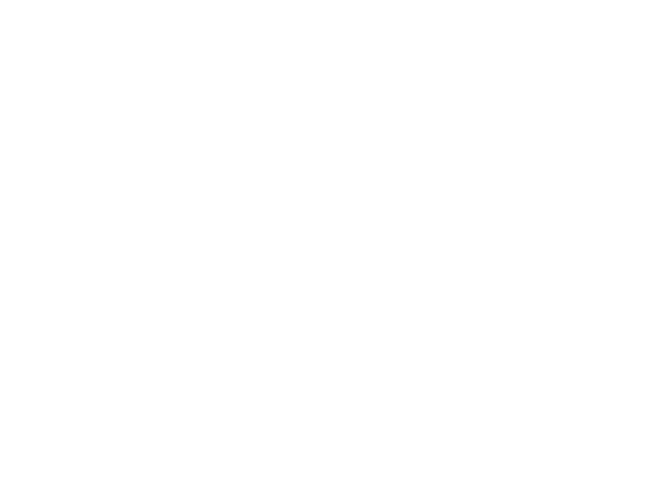

0



In [ ]:
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

# global depth
depth=25


# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()


# Рекурсия
model = GA_model('Тест дерева - рекурсия')
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=False)
append_new_element(pump, elements_sack, lst_left=True)  #, add_elmnts_p=1)


model.build(pump).check_pumps().interpretate()
NRS_Revision.print_model_elements(model)
print_NRS_graph(model)



# Удаление элемента:
# fire_dead_elements_try(model, hoseW3).check_pumps().interpretate()
for elmnt in model.elmnts.copy():
    print('вход в рекурсию', elmnt.name)
    fire_dead_elements_try(model, elmnt)
model.check_pumps().interpretate()
NRS_Revision.print_model_elements(model)
print_NRS_graph(model)

# Расчет
# model.calc(iters=10)
model.calc(accuracy=0.5)
print(model.summaryQ(), end='\n\n')

## Тест расчета деревьев без корня

Новая модель: Тест расчета деревьев без корня
11
all:
  НРЛ0
  Р1
  НРЛ2
  С3
in:
out:
  С3
Полный граф изобразить не возможно, будет отображен упрощенный


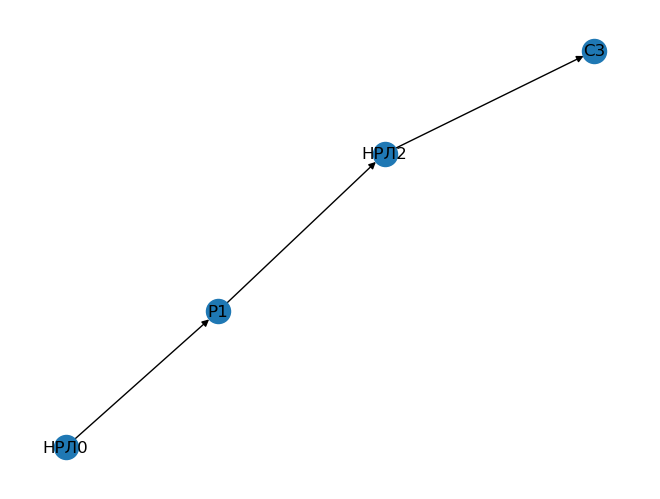

0.0



In [ ]:
# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()

# Рекурсия
model = GA_model('Тест расчета деревьев без корня')
print(len(elements_sack))
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
hoseM1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
splitter = pop_random_element_by_class(elements_sack, GA_Element_Splitter, lst_left=True)
hoseW1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW2 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW3 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)

# Живая линия
hoseM1.append(splitter).append(hoseW1).append(nozzle)
# Мертвая линия
# splitter.append(hoseW2).append(hoseW3)

model.addElements([hoseM1, splitter, hoseW1, nozzle]).check_pumps().interpretate()
NRS_Revision.print_model_elements(model)
print_NRS_graph(model)

# # Удаление элемента:
# # fire_dead_elements_try(model, hoseW3).check_pumps().interpretate()
# for elmnt in model.elmnts:
#     fire_dead_elements_try(model, elmnt).check_pumps().interpretate()
# NRS_Revision.print_model_elements(model)
# print_NRS_graph(model)

# Расчет
# model.calc(iters=10)
model.calc(accuracy=0.5)
print(model.summaryQ(), end='\n\n')

# Мутации

## Тест микромутаций

Микромутации - мутации в свойствах элементов

Новая модель: Тест микромутации
10
all:
  Н0
  НРЛ1
  Р2
  НРЛ3
  С4
  НРЛ5
  НРЛ6
  С7
in:
  Н0
out:
  С4
  С7
Общий расход системы: 11.735803924963227 л/с

Расстояние до Н0 160 м


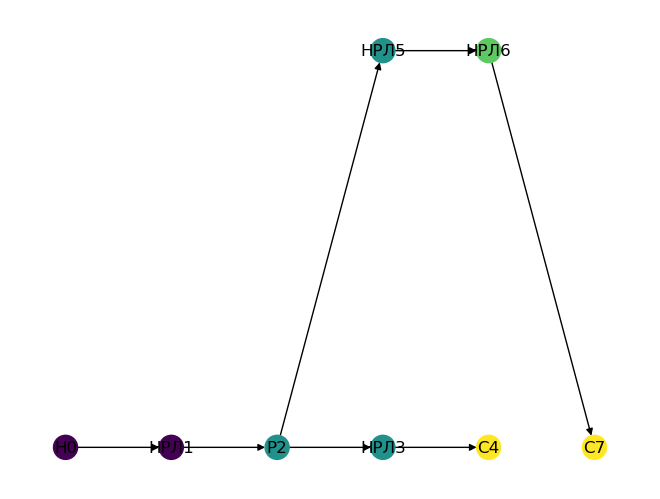

In [174]:
# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()

# Рекурсия
model = GA_model('Тест микромутации')
print(len(elements_sack))
pump = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
hoseM1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
splitter = pop_random_element_by_class(elements_sack, GA_Element_Splitter, lst_left=True)
hoseW1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW2 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW3 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle1 = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)
nozzle2 = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)

# Живая линия
pump.append(hoseM1).append(splitter).append(hoseW1).append(nozzle1)
# Мертвая линия
splitter.append(hoseW2).append(hoseW3).append(nozzle2)

model.build(pump).check_pumps().interpretate()
NRS_Revision.print_model_elements(model)

# Расчет
try:
    model.calc(accuracy=0.5)
except Exception as e:
    print(e.args[0])
print(f'Общий расход системы: {model.summaryQ()} л/с', end='\n\n')

# Схема НРС
print_NRS_graph(model)

In [175]:
model_original=copy.deepcopy(model)

In [14]:
for i in range(100):
    model_back = copy.deepcopy(model)
    curQ = model.summaryQ()
    try:
        model.mutate(mutation_count=2)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = model.summaryQ()
        if newQ<curQ:
            model = model_back
    except:
        print('Модель не жизнеспособна')
        model = model_back

    print(i, model.summaryQ(), end='\n')

0 57.637920852118214
1 57.637920852118214
2 57.637920852118214
3 57.637920852118214
4 57.637920852118214
5 57.637920852118214
6 57.637920852118214
7 57.637920852118214
8 57.637920852118214
9 57.637920852118214
Модель не жизнеспособна
10 57.637920852118214
11 57.637920852118214
12 57.637920852118214
13 57.637920852118214
14 57.637920852118214
15 57.637920852118214
16 57.637920852118214
17 57.637920852118214
18 57.637920852118214
19 57.637920852118214
20 57.64220746875372
21 57.64220746875372
22 57.64220746875372
23 57.64220746875372
24 57.64220746875372
25 57.64220746875372
26 57.64220746875372
27 57.64220746875372
28 57.64220746875372
29 57.64220746875372
30 57.64220746875372
31 57.64220746875372
32 57.64220746875372
33 57.64220746875372
34 57.64220746875372
35 57.64220746875372
H added
H added
36 57.64220746875372
37 57.64220746875372
38 57.64220746875372
39 57.64220746875372
40 57.64220746875372
41 57.64220746875372
42 57.64220746875372
H added
43 57.64220746875372
H added
44 58.7402

## Класс-Оценщик

In [53]:
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Hose):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)

# metrics = Appraiser.metrics(model)
# metrics

In [103]:
aims = {'Q':30, '110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'max_L': 100}
Appraiser.evaluate(metrics, aims)

0.6331716494310934

### Оптимизация модели с использованием Класса-оптимизатора

In [152]:
model = copy.deepcopy(model_original)

In [180]:
# aims = {'Q':15, '77':5, '89':0,'110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'max_L': 1000}
aims = {'Q':15, '77':5, '89':0,'200': 0, '225': 0, '250': 0, '300': 0, 'hoses':25, 'max_L': 500}

for i in range(1000):
    model_back = copy.deepcopy(model)
    curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
    try:
        model.mutate(mutation_count=2)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
        if newQ>curQ:
            model = model_back
    except:
        print('Модель не жизнеспособна')
        model = model_back

    # print(i, model.summaryQ(), end='\n')
    print(i, curQ, model.summaryQ(), sep='\t')

0	0.02738731672679584	14.963903853535106
Модель не жизнеспособна
1	0.02738731672679584	14.963903853535106
2	0.02738731672679584	14.963903853535106
3	0.02738731672679584	14.963903853535106
Модель не жизнеспособна
4	0.02738731672679584	14.963903853535106
5	0.02738731672679584	14.963903853535106
6	0.02738731672679584	14.963903853535106
7	0.02738731672679584	14.963903853535106
8	0.02738731672679584	14.963903853535106
9	0.02738731672679584	14.963903853535106
Модель не жизнеспособна
10	0.02738731672679584	14.963903853535106
11	0.02738731672679584	14.963903853535106
Модель не жизнеспособна
12	0.02738731672679584	14.963903853535106
13	0.02738731672679584	14.963903853535106
14	0.02738731672679584	14.963903853535106
15	0.02738731672679584	14.963903853535106
16	0.02738731672679584	14.963903853535106
Модель не жизнеспособна
17	0.02738731672679584	14.963903853535106
18	0.02738731672679584	14.963903853535106
19	0.02738731672679584	14.963903853535106
20	0.02738731672679584	14.963903853535106
21	0.027

In [182]:
Appraiser.print_GA_NRS_model_elements_state(model)

Насос (Н0); напор: 35 м; производительность: 14.963903853535106 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015
Рукавная линия (НРЛ3), длина: 60 м; диаметр: 77 мм; сопротивление 0.015
Рукавная линия (НРЛ5), длина: 260 м; диаметр: 150 мм; сопротивление 0.00046
Рукавная линия (НРЛ6), длина: 200 м; диаметр: 51нп мм; сопротивление 0.03

Ствол (С4): "Л"; проводимость: 2.5298221281347035; напор: 22.4417672984386, м; расход: 11.984461219012186, л/с
Ствол (С7): "Б"; проводимость: 0.5850213671311502; напор: 25.937409532250925, м; расход: 2.9794426345229197, л/с


In [183]:
Appraiser.print_GA_NRS_model_elements_state(model_original)

Насос (Н0); напор: 40 м; производительность: 11.735803924963227 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 80 м; диаметр: 77 мм; сопротивление 0.015
Рукавная линия (НРЛ3), длина: 80 м; диаметр: 77 мм; сопротивление 0.015
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 77 мм; сопротивление 0.015
Рукавная линия (НРЛ6), длина: 40 м; диаметр: 51 мм; сопротивление 0.13

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 28.789106986385914, м; расход: 6.277920632212733, л/с
Ствол (С7): "А"; проводимость: 1.1700427342623003; напор: 21.75930609005477, м; расход: 5.457883292750494, л/с


In [181]:
Appraiser.metrics(model)

{'hoses': 28,
 'nozzles': 0,
 'distances': {'Н0': {'С4': 100, 'С7': 500}},
 'min_L': 100,
 'max_L': 500,
 '77': 5,
 'Л': 1,
 '150': 13,
 '51нп': 10,
 'Б': 1,
 'Q': 14.963903853535106}

In [100]:
Appraiser.metrics(model_original)

{'distances': {'Н0': {'С4': 120, 'С7': 200}},
 'min_L': 120,
 'max_L': 200,
 '77': 12,
 'Б': 2,
 'Q': 7.009701034134398}

# Тест расчета для модели НРС с несколькими компонентами

Новая модель: Тест двухкомпонентной НРС
10
Общий расход системы: 10.778181324169724 л/с

all:
  Н0
  Н1
  НРЛ2
  НРЛ3
  С4
  С5
in:
  Н0
  Н1
out:
  С4
  С5
Насос (Н0); напор: 40 м; производительность: 7.115579962511559 л/с; напор макс.: 100
Насос (Н1); напор: 40 м; производительность: 3.6626013616581656 л/с; напор макс.: 100

Рукавная линия (НРЛ2), длина: 80 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 3.015720816 м
Рукавная линия (НРЛ3), длина: 80 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 0.804532551 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 36.984279184, м; расход: 7.115579962511559, л/с
Ствол (С5): "Б"; проводимость: 0.5850213671311502; напор: 39.195467449, м; расход: 3.6626013616581656, л/с
Расстояние до Н0 80 м
Расстояние до Н1 80 м


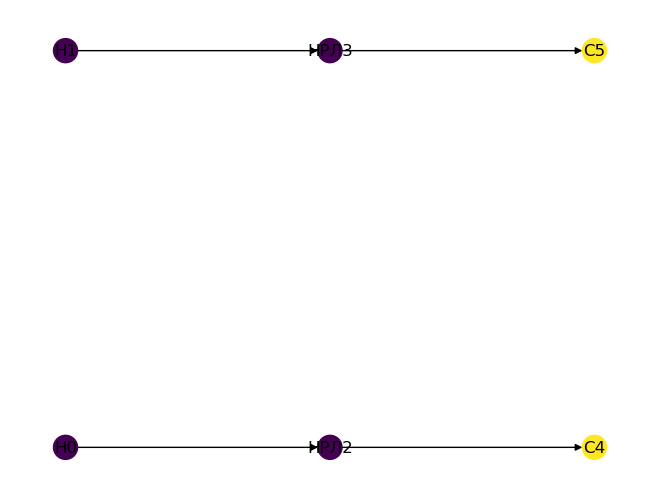

In [27]:
# Построение модели
# Копия списка элементов (чтобы каждый раз не создавать его заново)
elements_sack = get_elements_sack()

# Рекурсия
model = GA_model('Тест двухкомпонентной НРС')
print(len(elements_sack))
pump1 = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
pump2 = pop_random_element_by_class(elements_sack, GA_Element_Pump, lst_left=True)
# hoseM1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
# splitter = pop_random_element_by_class(elements_sack, GA_Element_Splitter, lst_left=True)
hoseW1 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
hoseW2 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
# hoseW3 = pop_random_element_by_class(elements_sack, GA_Element_Hose, lst_left=True)
nozzle1 = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)
nozzle2 = pop_random_element_by_class(elements_sack, GA_Element_Nozzle, lst_left=True)

# Первая линия
pump1.append(hoseW1).append(nozzle1)
# Вторая линия
pump2.append(hoseW2).append(nozzle2)

model.addElements([pump1, pump2, hoseW1, hoseW2, nozzle1, nozzle2]).check_pumps().interpretate()
# model.addElements([pump1, hoseW1, nozzle1])    #.check_pumps().interpretate()
# model.addElements([pump2, hoseW2, nozzle2]).check_pumps().interpretate()

# Расчет
try:
    model.calc(accuracy=0.05)
except Exception as e:
    print(e.args[0])
print(f'Общий расход системы: {model.summaryQ()} л/с', end='\n\n')

# Состав
NRS_Revision.print_model_elements(model)
Appraiser.print_GA_NRS_model_elements_state(model)

# Схема НРС
print_NRS_graph(model)

# Сохранение оригинала
model_original = copy.deepcopy(model)

In [32]:
model = copy.deepcopy(model_original)

Требуется убедиться, что все деревья будут рассчитаны одинаково (ну или близко)

In [36]:
aims = {'Q':15, '89':0,'110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'min_L': 400, 'max_L': 400}
# aims = {'Q':15, '77':5, '89':0,'200': 0, '225': 0, '250': 0, '300': 0, 'hoses':25, 'max_L': 500}

for i in range(1000):
    model_back = copy.deepcopy(model)
    curQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
    try:
        model.mutate(mutation_count=2)
        model.drop_q()
        kwargs = model.calc(accuracy=0.5)
        newQ = Appraiser.evaluate(Appraiser.metrics(model), aims)
        if newQ>curQ:
            model = model_back
    except:
        print('Модель не жизнеспособна')
        model = model_back

    print(i, curQ, model.summaryQ(), sep='\t')

0	0.33419058964149	14.96142346613295
1	0.33419058964149	14.96142346613295
2	0.33419058964149	14.96142346613295
Модель не жизнеспособна
3	0.33419058964149	14.96142346613295
4	0.33419058964149	14.96142346613295
5	0.33419058964149	14.96142346613295
6	0.33419058964149	14.96142346613295
7	0.33419058964149	14.96142346613295
Модель не жизнеспособна
8	0.33419058964149	14.96142346613295
9	0.33419058964149	14.96142346613295
10	0.33419058964149	14.96142346613295
11	0.33419058964149	14.96142346613295
12	0.33419058964149	14.96142346613295
13	0.33419058964149	14.96142346613295
14	0.33419058964149	14.96142346613295
15	0.33419058964149	14.96142346613295
16	0.33419058964149	14.96142346613295
17	0.33419058964149	14.96142346613295
Модель не жизнеспособна
18	0.33419058964149	14.96142346613295
19	0.33419058964149	14.96142346613295
Модель не жизнеспособна
20	0.33419058964149	14.96142346613295
21	0.33419058964149	14.96142346613295
22	0.33419058964149	14.96142346613295
23	0.33419058964149	14.96142346613295
Мо

In [57]:
Appraiser.print_GA_NRS_model_elements_state(model)
print('='*80)
Appraiser.print_metrics(model)

Насос (Н0); напор: 50 м; производительность: 7.006353063365839 л/с; напор макс.: 100
Насос (Н1); напор: 65 м; производительность: 7.988471582417794 л/с; напор макс.: 100

Рукавная линия (НРЛ2), длина: 400 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 14.14245197331199 м
Рукавная линия (НРЛ3), длина: 400 м; диаметр: 77 мм; сопротивление 0.015; потеря напора: 18.38518756530559 м

Ствол (С4): "А"; проводимость: 1.1700427342623003; напор: 35.85754802668801, м; расход: 7.006353063365839, л/с
Ствол (С5): "А"; проводимость: 1.1700427342623003; напор: 46.614812434694414, м; расход: 7.988471582417794, л/с
hoses	40
nozzles	2
distances	{'Н0': {'С4': 400}, 'Н1': {'С5': 400}}
min_L	400
max_L	400
77	40
А	2
Q	14.994824645783632
